In [4]:
# Import

# Basic
from time import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# ML
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

---
# Objective:

- Train a model to predict whether a user will default or not
- Evaluate the performance of model


---

# My plan

1. Load model and set up
2. Model the 6 selected features on a few other models 
    - tune hyper parameters
    - select the best model with k fold cross validation.
3. Tune probability threshold to improve accuracy
4. Show model performance


---
# 1. Load model and set up

In [5]:
df_trans = pd.read_pickle("df_trans.pkl")
feature_names = ['N_PAY_DULY', 'N_DELAYED', 'UTILIZE_PTG1', 'PAY_PTG1', 'PAY_1_delayed']

In [6]:
from sklearn.model_selection import train_test_split

# split the data
df_train,df_test = train_test_split(df_trans,test_size=0.2,random_state=2020)

In [7]:
# Check training data
d_rate = df_train.groupby(['DEFAULT_PAY']).size().reset_index(name='N_USERS')
d_rate['PTG'] = d_rate['N_USERS']/sum(d_rate['N_USERS'])
d_rate

,DEFAULT_PAY,N_USERS,PTG
0,0,6211,0.776375
1,1,1789,0.223625


In [8]:
# Check testing data
d_rate = df_test.groupby(['DEFAULT_PAY']).size().reset_index(name='N_USERS')
d_rate['PTG'] = d_rate['N_USERS']/sum(d_rate['N_USERS'])
d_rate

,DEFAULT_PAY,N_USERS,PTG
0,0,1551,0.7755
1,1,449,0.2245


In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

# get feature and labels
features_train, features_test = \
    df_train[feature_names].values, df_test[feature_names].values
labels_train, labels_test = \
    df_train['DEFAULT_PAY'].values,df_test['DEFAULT_PAY'].values

clf = GradientBoostingClassifier(n_estimators=35, 
                                 max_depth = 3, 
                                 min_samples_split = 100, 
                                 min_samples_leaf = 50,
                                 #max_features=10,
                                 random_state = 0)

# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")

# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.4904480722473081
F1 testing score: 0.4524137931034483
Training time: 0.176 s
Prediction time: 0.001 s
Accuracy training score: 0.816625
Accuracy testing score: 0.8015


---
# 2. Try a few more models

## 2.1. Gradient Boosted Tree

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": [100],
    "min_samples_leaf": [50],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "n_estimators":[35]
    }

acc_scorer = make_scorer(f1_score)
grid_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_clf = grid_clf.fit(features_train, labels_train)
best_clf_gbc = grid_clf.best_estimator_
print(grid_clf.best_estimator_)
print(grid_clf.best_score_)

CPU times: user 26.4 s, sys: 126 ms, total: 26.5 s
Wall time: 26.6 s
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=35,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.47955131152949837


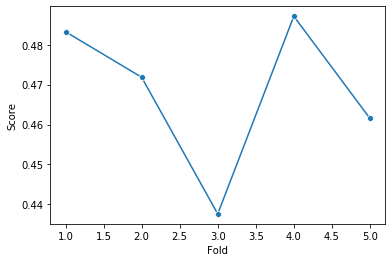

In [73]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=0,shuffle=True)

fold = []
scr = []

clf = best_clf_gbc

for i,(train_index, test_index) in enumerate(kf.split(df_trans)):
    # split into K Fold sets
    train = df_trans.iloc[train_index,:]
    test = df_trans.iloc[test_index,:]
    # re-define features and labels data sets
    features_train = train[feature_names]
    labels_train = train['DEFAULT_PAY']
    features_test = test[feature_names]
    labels_test = test['DEFAULT_PAY']
    # fit and predict
    clf.fit(features_train, labels_train)
    predictions = clf.predict(features_test)
    # get f1 score
    score = f1_score(y_true = labels_test, y_pred = predictions)
    # store results
    fold.append(i+1)
    scr.append(score)
    
#create a small df with the scores
performance = pd.DataFrame({'Score':scr,'Fold':fold})

# show result of each fold
ax = sns.lineplot(x="Fold", y="Score",
                  marker="o",
                  markers=True, dashes=False, data=performance)

In [74]:
# average f1 score
performance.Score.mean()

0.4682770895351365

---
## 2.2. Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "min_samples_split": [100, 150, 200],
    "min_samples_leaf": [50],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "n_estimators":[35,100]
    }

acc_scorer = make_scorer(f1_score)
grid_clf = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_clf = grid_clf.fit(features_train, labels_train)
best_clf_rf = grid_clf.best_estimator_
print(grid_clf.best_estimator_)
print(grid_clf.best_score_)

CPU times: user 37.2 s, sys: 350 ms, total: 37.5 s
Wall time: 37.6 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.48363897890545465


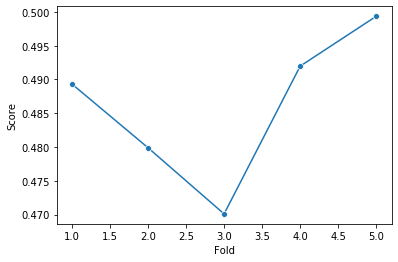

In [75]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=0,shuffle=True)

fold = []
scr = []

clf = best_clf_rf

for i,(train_index, test_index) in enumerate(kf.split(df_trans)):
    # split into K Fold sets
    train = df_trans.iloc[train_index,:]
    test = df_trans.iloc[test_index,:]
    # re-define features and labels data sets
    features_train = train[feature_names]
    labels_train = train['DEFAULT_PAY']
    features_test = test[feature_names]
    labels_test = test['DEFAULT_PAY']
    # fit and predict
    clf.fit(features_train, labels_train)
    predictions = clf.predict(features_test)
    # get f1 score
    score = f1_score(y_true = labels_test, y_pred = predictions)
    # store results
    fold.append(i+1)
    scr.append(score)
    
#create a small df with the scores
performance = pd.DataFrame({'Score':scr,'Fold':fold})

# show result of each fold
ax = sns.lineplot(x="Fold", y="Score",
                  marker="o",
                  markers=True, dashes=False, data=performance)

In [76]:
# average f1 score
performance.Score.mean()

0.4861333399484719

---
## 2.3. XG Boost

In [79]:
from xgboost import XGBClassifier

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1],
    'max_depth': [3],
    'gamma': [0.5, 1, 2, 5],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'n_estimators': [300]
    }

acc_scorer = make_scorer(f1_score)
grid_clf = GridSearchCV(XGBClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_clf = grid_clf.fit(features_train, labels_train)
best_clf_xgbc = grid_clf.best_estimator_
print(grid_clf.best_estimator_)
print(grid_clf.best_score_)

CPU times: user 29min 14s, sys: 59 s, total: 30min 13s
Wall time: 2min 59s
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)
0.47465925362437955


Result copied to below (because it takes too long to re-run):

- CPU times: user 29min 14s, sys: 59 s, total: 30min 13s
- Wall time: 2min 59s
- XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)
- 0.47465925362437955

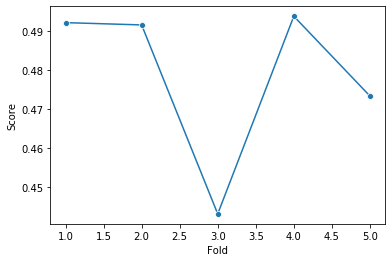

In [80]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=0,shuffle=True)

fold = []
scr = []

clf = best_clf_xgbc

for i,(train_index, test_index) in enumerate(kf.split(df_trans)):
    # split into K Fold sets
    train = df_trans.iloc[train_index,:]
    test = df_trans.iloc[test_index,:]
    # re-define features and labels data sets
    features_train = train[feature_names]
    labels_train = train['DEFAULT_PAY']
    features_test = test[feature_names]
    labels_test = test['DEFAULT_PAY']
    # fit and predict
    clf.fit(features_train, labels_train)
    predictions = clf.predict(features_test)
    # get f1 score
    score = f1_score(y_true = labels_test, y_pred = predictions)
    # store results
    fold.append(i+1)
    scr.append(score)
    
#create a small df with the scores
performance = pd.DataFrame({'Score':scr,'Fold':fold})

# show result of each fold
ax = sns.lineplot(x="Fold", y="Score",
                  marker="o",
                  markers=True, dashes=False, data=performance)

In [81]:
# average f1 score
performance.Score.mean()

0.4788537862951595

---
## Chosen model

Random Forest has the lowest average f1 score (0.486). Therefore, it is the chosen model (see below).

- RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


---
# 3. Tuning probability threshold to improve accuracy

The default threshold is 0.5.


In [104]:
from sklearn.metrics import f1_score
from sklearn import metrics

# get feature and labels
features_train, features_test = \
    df_train[feature_names].values, df_test[feature_names].values
labels_train, labels_test = \
    df_train['DEFAULT_PAY'].values,df_test['DEFAULT_PAY'].values

clf = best_clf_rf

# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")

# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.49700996677740866
F1 testing score: 0.47011952191235057
Training time: 0.118 s
Prediction time: 0.006 s
Accuracy training score: 0.81075
Accuracy testing score: 0.8005


In [105]:
clf_prob = clf.predict_proba(features_test)[:,1]

df_test_result = pd.DataFrame({'actual_values':labels_test, 'prediction': pd.Series(clf_prob),'prediction-yn': predictions})

df_test_result.head(5)


,actual_values,prediction,prediction-yn
0,0,0.126466,0
1,0,0.154165,0
2,0,0.112958,0
3,0,0.352943,0
4,1,0.144335,0


In [84]:
#Compute Classifier's Accuracy for various thresholds 

def _compute_accuracy_for_thresholds(data: pd.core.frame.DataFrame):

    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    for threshold in thresholds:
        preds = df_test_result['prediction'].map(lambda x: 1 if x > threshold else 0)
        accuracy_ = metrics.accuracy_score(df_test_result['actual_values'].values, preds)
        accuracies.append(accuracy_)
    return accuracies, thresholds

accuracies, threshold = _compute_accuracy_for_thresholds(df_test_result)

max_value = np.amax(accuracies)
max_position = np.where(accuracies == max_value)
print("maximum accuracies: {}; maximum threshold: {}".format(max_value, threshold[max_position]))


maximum accuracies: 0.8055; maximum threshold: [0.54545455]


(0.7, 0.85)

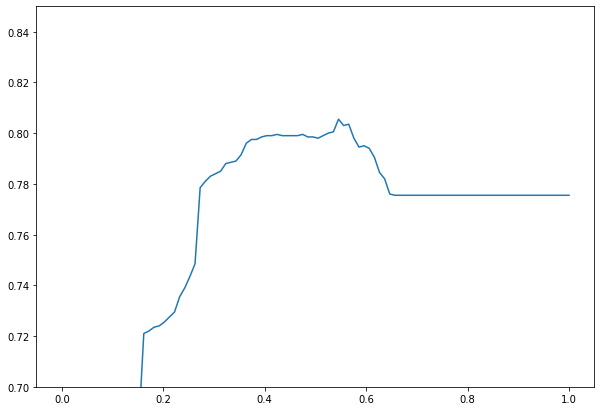

In [85]:
plt.figure(figsize=(10,7))

ax = sns.lineplot(x=threshold, y=accuracies,
                  markers=True, dashes=False)

axes = ax.axes
axes.set_ylim(0.7,0.85)


The highest point is around 0.5, not too far off from the default setting. With this new threshold, I am able to achieve an accuracy of 0.8055.

---
# 4. Show model performance and prediction

---
## Model accuracy (Accuracy = TP+TN/TP+FP+FN+TN)

With this new threshold, I am able to achieve an accuracy of 0.8055. It is considered low because if we had an extremely naive model that would classify all users as no default, we would still get 77.5% accuracy (77.5% of the users has not default so they were classified correctly).  This means that the chosen model is only predicting slightly better than this super naive model in terms of accuracy.

But in terms of precision and recall, this model is better than that. Let's look at the confusion matrix.

---
## Confusion Matrix

Confusion matrix, without normalization
[[1456   95]
 [ 313  136]]


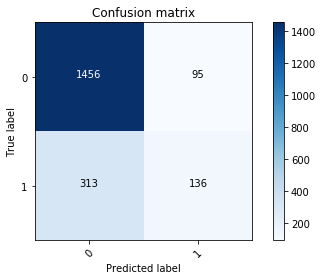

In [112]:
# Confusion matrix: where is the problem

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cnf_matrix = confusion_matrix(df_test_result['actual_values'], df_test_result['prediction_new'])

plot_confusion_matrix(cnf_matrix,classes=[0,1])

### Precision = TP/TP+FP
Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. 

In [11]:
136/(136+95)

0.5887445887445888

The question that this metric answer is of all users that labeled as default, how many actually defaulted? High precision relates to the low false positive rate. We have got 0.59 precision, which has room to be improved.

### Recall = TP/TP+FN
Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. 

In [12]:
136/(136+313)

0.3028953229398664

The question recall answers is: Of all the users that truly defaulted, how many did we label? We have got recall of 0.30 which is bad for this model as it’s below 0.5.

### Led to a low f1 score
The low performance in both precision and recall contribute to the low f1 score. Both the model and features would need more work to improve the F1 score. In the next section, I have explained a few things that I would like to do, if I had more time.

---
## So, how good is the prediction?
The ultimate task is to predict the default rate for the credit card company. So, how good was it?

### Default rate: prediction based on test data set

In [111]:
df_test_result['prediction_new'] = df_test_result['prediction'].apply(lambda x: 1 if x>0.54545455 else 0)
df_test_result.sample(5)

,actual_values,prediction,prediction-yn,prediction_new
982,0,0.139599,0,0
550,0,0.115275,0,0
1223,0,0.124502,0,0
586,1,0.144339,0,0
526,0,0.132140,0,0


In [114]:
df_test_result['prediction'].sum()/len(df_test_result['prediction'])

0.22407648739827443

### Default rate: actual defaults based on test data set

In [9]:
df_test['DEFAULT_PAY'].sum()/len(df_test['DEFAULT_PAY'])

0.2245

### Ultimately, the predicted rate is quite accurate.
The predicted default rate is only 0.2% off, when compared to the the actual default rate.

---
# If I had more time, I would like to ...

- work with the data provider to understand some of the weird labelling (-2 in pay) and abnormal values (negative billing amount).
- use various techniques to deal with the imbalance sample, such as class weight and upsampling.
- find a better way to deal with time series data, rather than eliminating all of them.
- try out a few more classification algorithms. 